## POS tagging using modified Viterbi

# Objective:
    1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
    2. Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
    3. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
    4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import random
import requests
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import pos_tag
import pprint,time

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# first few tagged sentences
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
#Lenght of data
len(nltk_data)

3914

# Split test and train data

In [5]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size=0.05 ,random_state=42)

In [6]:
len(train_set);

In [7]:
len(test_set)

196

In [8]:
train_set[:5]

[[('Bank', 'NOUN'),
  ('of', 'ADP'),
  ('New', 'NOUN'),
  ('England', 'NOUN'),
  ("'s", 'PRT'),
  ('shares', 'NOUN'),
  ('are', 'VERB'),
  ('traded', 'VERB'),
  ('*-1', 'X'),
  ('on', 'ADP'),
  ('the', 'DET'),
  ('New', 'NOUN'),
  ('York', 'NOUN'),
  ('Stock', 'NOUN'),
  ('Exchange', 'NOUN'),
  ('.', '.')],
 [('$', '.'),
  ('130', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('of', 'ADP'),
  ('general', 'ADJ'),
  ('obligation', 'NOUN'),
  ('distributable', 'ADJ'),
  ('state', 'NOUN'),
  ('aid', 'NOUN'),
  ('bonds', 'NOUN'),
  ('due', 'ADJ'),
  ('1991-2000', 'NUM'),
  ('and', 'CONJ'),
  ('2009', 'NUM'),
  (',', '.'),
  ('tentatively', 'ADV'),
  ('priced', 'VERB'),
  ('*', 'X'),
  ('by', 'ADP'),
  ('a', 'DET'),
  ('Chemical', 'NOUN'),
  ('Securities', 'NOUN'),
  ('Inc.', 'NOUN'),
  ('group', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('yield', 'VERB'),
  ('from', 'ADP'),
  ('6.20', 'NUM'),
  ('%', 'NOUN'),
  ('in', 'ADP'),
  ('1991', 'NUM'),
  ('to', 'PRT'),
  ('7.272', 'NUM'),
  ('%',

In [9]:
test_set[:10]

[[('For', 'ADP'),
  ('the', 'DET'),
  ('Agency', 'NOUN'),
  ('for', 'ADP'),
  ('International', 'NOUN'),
  ('Development', 'NOUN'),
  (',', '.'),
  ('appropriators', 'NOUN'),
  ('approved', 'VERB'),
  ('$', '.'),
  ('200', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('in', 'ADP'),
  ('secondary', 'ADJ'),
  ('loan', 'NOUN'),
  ('guarantees', 'NOUN'),
  ('under', 'ADP'),
  ('an', 'DET'),
  ('expanded', 'VERB'),
  ('trade', 'NOUN'),
  ('credit', 'NOUN'),
  ('insurance', 'NOUN'),
  ('program', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('total', 'ADJ'),
  ('loan', 'NOUN'),
  ('guarantees', 'NOUN'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('Overseas', 'NOUN'),
  ('Private', 'NOUN'),
  ('Investment', 'NOUN'),
  ('Corp.', 'NOUN'),
  ('are', 'VERB'),
  ('increased', 'VERB'),
  ('*-3', 'X'),
  ('by', 'ADP'),
  ('$', '.'),
  ('40', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('over', 'ADP'),
  ('fiscal', 'ADJ'),
  ('1989', 'NUM'),
  ('as', 'ADP'),
  ('part', 'NOUN'),
  ('of', 'ADP'),
  ('

In [10]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95589

In [11]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [12]:
# number of tags
train_data_pos_tags = [pair[1] for pair in train_tagged_words]
train_data_pos_tags[:10]

['NOUN', 'ADP', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'VERB', 'VERB', 'X', 'ADP']

In [13]:
# vocabulary
train_voc_set= set(tokens)
len(train_voc_set)

12109

In [14]:
train_pos_tag_set= set(train_data_pos_tags)
len(train_pos_tag_set)

12

### Build the vanilla Viterbi based POS tagger

In [15]:
# computing P(w/t) and storing in T x V matrix
len_pos_tags = len(train_pos_tag_set)
len_vocab = len(train_voc_set)

word_given_tag = np.zeros((len_pos_tags, len_vocab))

In [16]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    tag_count = Counter(tag_list)
    count_w_given_tag = tag_count[(word,tag)]
    
    return (count_w_given_tag, count_tag)

In [17]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [18]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(train_pos_tag_set)):
    for j, t2 in enumerate(list(train_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

# Display the matrix
tags_matrix

array([[1.72284637e-02, 3.26377749e-01, 8.23970046e-03, 1.31621184e-02,
        3.94863561e-02, 1.05296947e-01, 1.49812736e-03, 3.21776360e-01,
        6.91278726e-02, 8.56072758e-04, 3.40288915e-02, 6.29213452e-02],
       [9.05359723e-03, 5.31144394e-03, 3.83872539e-02, 1.23128919e-02,
        1.79864801e-02, 2.04973444e-01, 2.41429268e-04, 6.40028954e-01,
        3.74215352e-03, 4.82858537e-04, 4.55094166e-02, 2.19700634e-02],
       [9.04928222e-02, 1.33100510e-01, 1.69188976e-01, 8.25766400e-02,
        3.53123769e-02, 6.46488145e-02, 3.11214589e-02, 1.10904150e-01,
        3.62436958e-02, 5.58789307e-03, 2.18005434e-01, 2.28172299e-02],
       [1.19601332e-01, 6.71096370e-02, 3.44518274e-01, 8.10631216e-02,
        1.36877075e-01, 1.30232558e-01, 1.36212623e-02, 3.08970101e-02,
        1.56146176e-02, 6.31229253e-03, 2.35880390e-02, 3.05647831e-02],
       [9.11135077e-02, 1.73502430e-01, 8.85051265e-02, 5.20777106e-02,
        9.38118398e-02, 4.49721180e-02, 2.33855005e-03, 2.23

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_pos_tag_set), index=list(train_pos_tag_set))

# display dataset
tags_df

,ADP,DET,VERB,ADV,.,ADJ,PRT,NOUN,PRON,CONJ,X,NUM
ADP,0.017228,0.326378,0.008240,0.013162,0.039486,0.105297,0.001498,0.321776,0.069128,0.000856,0.034029,0.062921
DET,0.009054,0.005311,0.038387,0.012313,0.017986,0.204973,0.000241,0.640029,0.003742,0.000483,0.045509,0.021970
VERB,0.090493,0.133101,0.169189,0.082577,0.035312,0.064649,0.031121,0.110904,0.036244,0.005588,0.218005,0.022817
ADV,0.119601,0.067110,0.344518,0.081063,0.136877,0.130233,0.013621,0.030897,0.015615,0.006312,0.023588,0.030565
.,0.091114,0.173502,0.088505,0.052078,0.093812,0.044972,0.002339,0.223152,0.065389,0.057924,0.026623,0.080500
ADJ,0.078986,0.005101,0.012342,0.004608,0.065328,0.066645,0.010861,0.696725,0.000658,0.016949,0.021392,0.020405
PRT,0.021576,0.100360,0.402746,0.010134,0.041517,0.086303,0.001635,0.242563,0.018960,0.002288,0.013403,0.058516
NOUN,0.176275,0.013310,0.147978,0.016884,0.239179,0.012289,0.043832,0.264632,0.004923,0.041936,0.029136,0.009627
PRON,0.022918,0.009549,0.480901,0.033995,0.041253,0.074866,0.012223,0.211230,0.008021,0.004966,0.092819,0.007257
CONJ,0.054435,0.121539,0.153918,0.055842,0.034256,0.116847,0.004693,0.349132,0.058658,0.000469,0.007977,0.042234


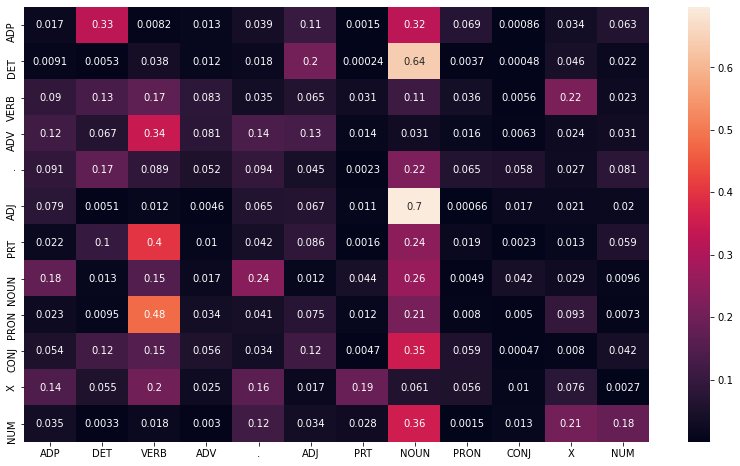

In [20]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(14, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

From heqtmap we can see most tags are noun and verb. we also see a significant amount of X.

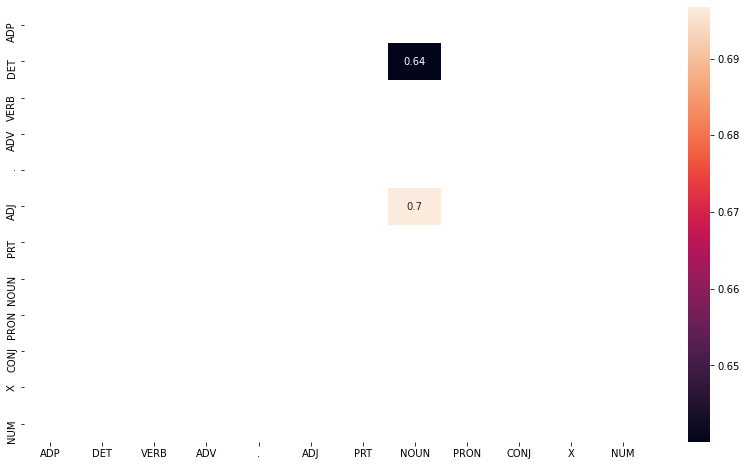

In [21]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(14, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

We see the most common tag is Noun preceeded by Determinant and preceededby adjective.

In [22]:
len(train_tagged_words)

95589

In [23]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [24]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Shearson', 'NOUN'),
  ('``', '.'),
  ('really', 'ADV'),
  ('only', 'ADV'),
  ('has', 'VERB'),
  ('$', '.'),
  ('300', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('of', 'ADP'),
  ('capital', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('says', 'VERB'),
  ('*T*-1', 'X'),
  ('Mr.', 'NOUN'),
  ('Bowman', 'NOUN'),
  ('of', 'ADP'),
  ('S&P', 'NOUN'),
  ('.', '.')],
 [('ShareData', 'NOUN'),
  ('develops', 'VERB'),
  ('and', 'CONJ'),
  ('markets', 'VERB'),
  ('low-cost', 'ADJ'),
  ('software', 'NOUN'),
  (',', '.'),
  ('peripheral', 'ADJ'),
  ('equipment', 'NOUN'),
  ('and', 'CONJ'),
  ('accessories', 'NOUN'),
  ('for', 'ADP'),
  ('computers', 'NOUN'),
  ('.', '.')],
 [('Moscow', 'NOUN'),
  ('has', 'VERB'),
  ('settled', 'VERB'),
  ('pre-1917', 'ADJ'),
  ('debts', 'NOUN'),
  ('with', 'ADP'),
  ('other', 'ADJ'),
  ('countries', 'NOUN'),
  ('in', 'ADP'),
  ('recent', 'ADJ'),
  ('years', 'NOUN'),
  ('at', 'ADP'),
  ('less', 'ADJ'),
  ('than', 'ADP'),
  ('face', 'NOUN'),
  ('value', 'NOUN'),


In [25]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  100.46312880516052
[('Shearson', 'NOUN'), ('``', '.'), ('really', 'ADV'), ('only', 'ADV'), ('has', 'VERB'), ('$', '.'), ('300', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('capital', 'NOUN'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Mr.', 'NOUN'), ('Bowman', 'NOUN'), ('of', 'ADP'), ('S&P', 'NOUN'), ('.', '.'), ('ShareData', 'NOUN'), ('develops', 'ADP'), ('and', 'CONJ'), ('markets', 'NOUN'), ('low-cost', 'ADP'), ('software', 'NOUN'), (',', '.'), ('peripheral', 'ADJ'), ('equipment', 'NOUN'), ('and', 'CONJ'), ('accessories', 'NOUN'), ('for', 'ADP'), ('computers', 'NOUN'), ('.', '.'), ('Moscow', 'NOUN'), ('has', 'VERB'), ('settled', 'VERB'), ('pre-1917', 'ADP'), ('debts', 'NOUN'), ('with', 'ADP'), ('other', 'ADJ'), ('countries', 'NOUN'), ('in', 'ADP'), ('recent', 'ADJ'), ('years', 'NOUN'), ('at', 'ADP'), ('less', 'ADJ'), ('than', 'ADP'), ('face', 'NOUN'), ('value', 'NOUN'), ('.', '.'), ('When', 'ADV'), ('test', 'VERB'), ('booklets',

In [26]:
#calculate accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

vanilla_viterbi_accuracy = len(check)/len(tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm is -", vanilla_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm is - 0.9142857142857143


In [27]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
incorrect_tagged_cases

18


[[('ShareData', 'NOUN'), (('develops', 'ADP'), ('develops', 'VERB'))],
 [('and', 'CONJ'), (('markets', 'NOUN'), ('markets', 'VERB'))],
 [('markets', 'VERB'), (('low-cost', 'ADP'), ('low-cost', 'ADJ'))],
 [('settled', 'VERB'), (('pre-1917', 'ADP'), ('pre-1917', 'ADJ'))],
 [('When', 'ADV'), (('test', 'VERB'), ('test', 'NOUN'))],
 [('*-1', 'X'), (('out', 'PRT'), ('out', 'ADV'))],
 [('she', 'PRON'), (('copied', 'ADP'), ('copied', 'VERB'))],
 [('totaled', 'VERB'), (('154.2', 'ADP'), ('154.2', 'NUM'))],
 [('been', 'VERB'), (('enormously', 'ADP'), ('enormously', 'ADV'))],
 [('enormously', 'ADV'), (('frustrating', 'ADP'), ('frustrating', 'VERB'))],
 [('computer', 'NOUN'), (('science', 'ADP'), ('science', 'NOUN'))],
 [('was', 'VERB'), (('raring', 'ADP'), ('raring', 'ADJ'))],
 [('to', 'PRT'), (('invent', 'ADP'), ('invent', 'VERB'))],
 [('another', 'DET'), (('Walkman', 'ADP'), ('Walkman', 'NOUN'))],
 [('was', 'VERB'), (('soliciting', 'ADP'), ('soliciting', 'VERB'))],
 [('sell', 'VERB'), (('TXO', 

In [28]:
#Checking unknowns
test_vocabulary_set = set([t for t in test_tagged_words])

unknown_words = list(test_vocabulary_set - train_voc_set)
print("Total Unknown words :", len(unknown_words))
print("\n")
print("Unknown Words :", unknown_words)

Total Unknown words : 15


Unknown Words : ['pre-1917', 'Walkman', '154.2', 'science', 'enormously', 'frustrating', 'manmade-fiber', 'soliciting', 'raring', 'invent', 'TXO', 'low-cost', '405', 'copied', 'develops']


we see the words mostly to be hyphened words,numbers , some of them are verb,adverb. These can be tagged correctly by adding rule based tagging. 

### Solve the problem of unknown words

### Approach 1 : Using Lexicon and rule based tagger

1. Unigram tagger

In [29]:
#Evaluating using unigram tagger

unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger is -", accuracy_unigram_tagger)

The accuracy of the Unigram Tagger is - 0.911735797129939


2. Rule based regex tagger

In [30]:
# patterns for tagging using a rule based regex tagger -

patterns = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'),
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

In [31]:
#building the tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# unigram tagger backed up by the rule-based tagger
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)

accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)

print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is -", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is - 0.9378808728130529


3.Bigram tagger

In [32]:
#bigram tagger
bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.9412227245920975


4. Trigram tagger

In [33]:
#trigram tagger
trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger backed up by the bigram_tagger is -", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger backed up by the bigram_tagger is - 0.9404364065264399


### Approach 2 : Modifying Viterbi for unknown words

For unknown words , let us consider transistion probablity as emission probability would be zero. 

In [34]:
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [35]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi for Unknown Words Accuracy: ',accuracy*100)

Time taken in seconds:  74.61628532409668
Vanilla Viterbi for Unknown Words Accuracy:  93.80952380952381


### Approach 3: Adding tag occurence probabilty weights to transition probability for predicting unknown words

We assign tags based on the most frequently occuring tag for those words.

In [36]:
#tag occurence probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in train_pos_tag_set:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('ADP', 0.09776229482471832),
 ('DET', 0.08666269131385411),
 ('VERB', 0.1347958447101654),
 ('ADV', 0.03148897885739991),
 ('.', 0.11631045413175156),
 ('ADJ', 0.06357426063668414),
 ('PRT', 0.032001590141125025),
 ('NOUN', 0.286884474154976),
 ('PRON', 0.02738808858759899),
 ('CONJ', 0.022293360114657546),
 ('X', 0.0656560901358943),
 ('NUM', 0.035181872391174714)]

In [37]:
def Vanilla_Viterbi_for_Unknown_Words_Modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [38]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi_for_Unknown_Words_Modified(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_viterbi_modified = len(viterbi_word_check)/len(tagged_seq) * 100
print('Modified Vanilla Viterbi for Unknown Words Accuracy: ', accuracy_viterbi_modified)

Time taken in seconds:  74.18387532234192
Modified Vanilla Viterbi for Unknown Words Accuracy:  93.33333333333333


Approach 4: Combining a little bit of all

Lets use trigram tagger backed with rule based and implemet to viterbi

In [39]:
def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),             # eg.- Laziness,goodness
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- photographers, teachers
    (r'.*ment$', 'NOUN'),             # eg.- enjoyment
    (r'.*town$', 'NOUN'),             # eg.- hometown,downtown
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [40]:
def Viterbi_Trigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in train_voc_set:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [41]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Trigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(tagged_seq) * 100
print('Modified Viterbi Trigram Tagger Accuracy: ', viterbi_trigram_accuracy)

Time taken in seconds:  125.2410078048706
Modified Viterbi Trigram Tagger Accuracy:  96.66666666666667


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [42]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy * 100], 
                  ['Vanilla Viterbi Modified', accuracy_viterbi_modified], 
                  ['Unigram Tagger', accuracy_unigram_tagger * 100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger * 100],
                  ['Bigram Tagger + RegexpTagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df


,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,91.428571
Vanilla Viterbi Modified,93.333333
Unigram Tagger,91.173580
Unigram + RegexpTagger,93.788087
Bigram Tagger + RegexpTagger,94.122272
Trigram Tagger + Bigram_tagger,94.043641
Viterbi + Trigram_tagger,96.666667


We see Viterbi with Trigram back by rule based to have the highest accuracy of ~97. The second best is the Bigram with Rule based tagger

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

Picking random sentences from the test file and comparing the results

### Sentence_test_1 = 'Android is a mobile operating system developed by Google.'

In [43]:
sentence_test_1 = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test_1)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]


In [44]:
tagged_seq_modified = bigram_tagger.tag(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'VERB'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [45]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


##### WE see Android and Google to be correctly tagged to Noun by both taggers. Interesting point to note is that operating gets tagged as verb by bigram however viterbi tags it back to noun

### Sentence_test_2='The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years'

In [46]:
sentence_test_2='The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years'
words = word_tokenize(sentence_test_2)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('The', 'DET'), ('2018', 'ADP'), ('FIFA', 'ADP'), ('World', 'NOUN'), ('Cup', 'ADP'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'ADP'), ('FIFA', 'ADP'), ('World', 'NOUN'), ('Cup', 'ADP'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'ADP'), ('contested', 'ADP'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN')]


In [47]:
tagged_seq_modified = bigram_tagger.tag(words)
print(tagged_seq_modified)

[('The', 'DET'), ('2018', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'NOUN'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN')]


In [48]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN')]


##### Fifa World cup is getting correctly tagged as Noun and 21st and years as number

### Sentence_test_3='NASA invited social media users to experience the launch of ICESAT-2 Satellite'

In [49]:
sentence_test_3='NASA invited social media users to experience the launch of ICESAT-2 Satellite'
words = word_tokenize(sentence_test_3)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('NASA', 'ADP'), ('invited', 'ADP'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'ADP'), ('Satellite', 'ADP')]


In [50]:
tagged_seq_modified = bigram_tagger.tag(words)
print(tagged_seq_modified)

[('NASA', 'NOUN'), ('invited', 'NOUN'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN')]


In [51]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN')]


##### NASA getting tagged as noun and invited getting tagged as verb

### Sentence_test_4='Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'

In [52]:
sentence_test_4='Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
words = word_tokenize(sentence_test_4)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'ADP'), ('with', 'ADP'), ('messages', 'ADP'), ('known', 'ADJ'), ('as', 'ADP'), ('tweets', 'ADP'), ('.', '.')]


In [53]:
tagged_seq_modified = bigram_tagger.tag(words)
print(tagged_seq_modified)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'NOUN'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


In [54]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


##### Twitter getting tagged as noun and tweets are also getting correctly tagged as noun

### Sentence_test_5='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'

In [55]:
sentence_test_5='Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test_5)
tagged_seq = Vanilla_Viterbi(words)
print(tagged_seq)

[('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.')]


In [56]:
tagged_seq_modified = bigram_tagger.tag(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]


In [57]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


##### smartphones as noun and years are getting tagged as numbers 